In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

# Magic function to render matplotlib graphs in jupyter notebooks
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Always make good looking plots!
plt.style.use('ggplot')

In [2]:
data = pd.read_csv("housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Removing 'ocean_proximity' variable
data.drop("ocean_proximity", axis=1, inplace=True)
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [4]:
# Checking missing values
data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

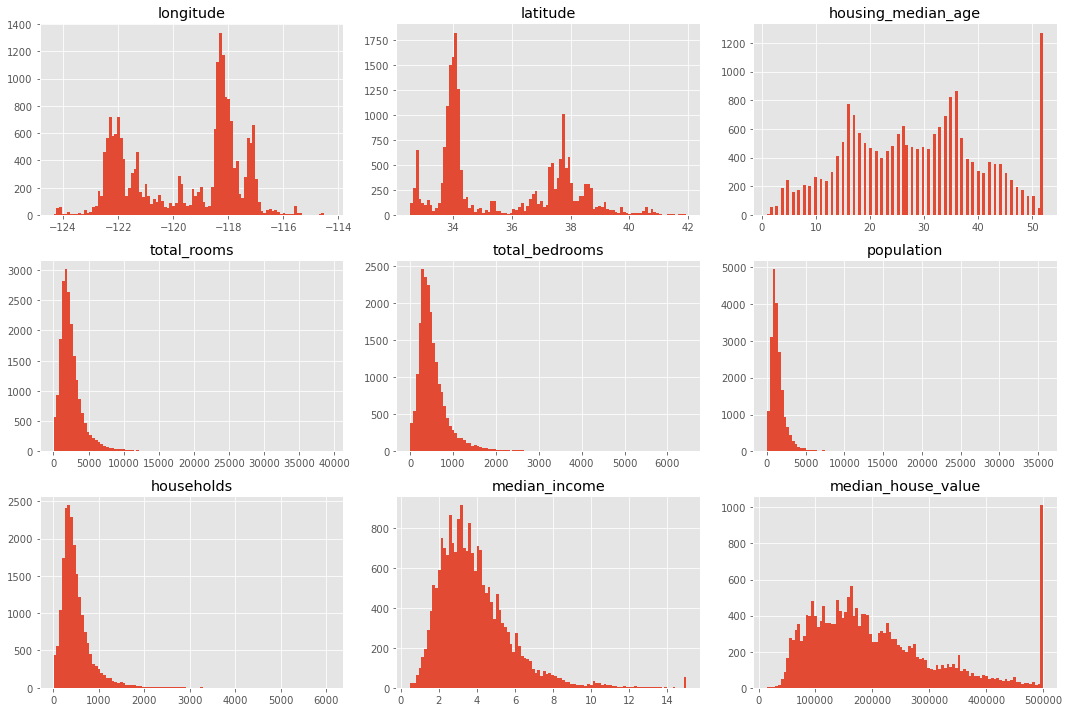

In [5]:
# Checking for the distribution of each of the variables
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
data.hist(column=[
    "longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms",
    "population", "households", "median_income", "median_house_value"
], bins=100, ax=ax, layout=(3, 3))
plt.tight_layout()
plt.show()

In [6]:
# Removing houses with prices above 500k USD
data = data[data["median_house_value"] < 500001]

In [7]:
# Removing 'latitude' and 'longitude' from the dataset
base = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', "median_house_value"]
data = data[base]
data.columns

Index(['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
       'households', 'median_income', 'median_house_value'],
      dtype='object')

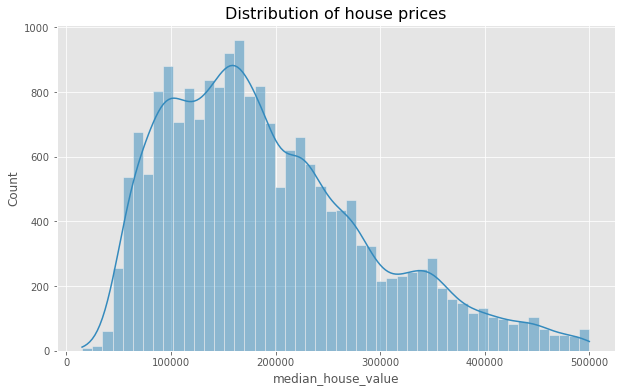

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data["median_house_value"], kde=True)
plt.title("Distribution of house prices", fontsize=16)
plt.show()

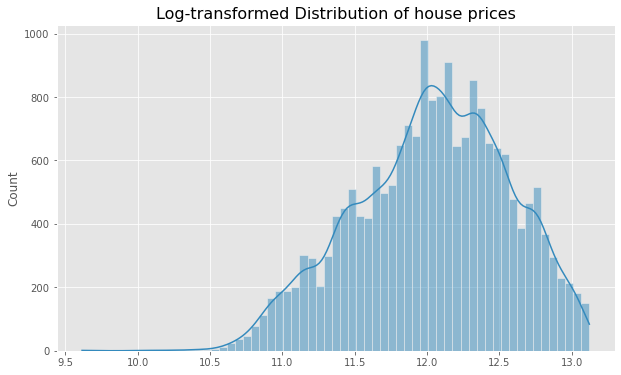

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(data["median_house_value"].values), kde=True)
plt.title("Log-transformed Distribution of house prices", fontsize=16)
plt.show()

Setting up training, validation and testing subsets

In [10]:
# Splitting data into training and testing subsets
df_train_full, df_test = train_test_split(data, test_size=0.2, random_state=1)

# Splitting data into training, validation and testing subsets
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [11]:
# Filling up missing values with the mean
df_train = df_train.fillna(df_train["total_bedrooms"].mean())
df_val = df_val.fillna(df_val["total_bedrooms"].mean())
df_test = df_test.fillna(df_test["total_bedrooms"].mean())

In [12]:
# Transforming to log() and defining target variables for each subset
y_train = np.log1p(df_train["median_house_value"].values)
y_val = np.log1p(df_val["median_house_value"].values)
y_test = np.log1p(df_test["median_house_value"].values)

In [13]:
# Deleting target variables from subsets to avoid perfect fitting
del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

Training and Validating the model

In [14]:
# Creating and training linear regression model
model = LinearRegression()
model.fit(df_train, y_train)

LinearRegression()

In [15]:
# Validating the model
y_pred = model.predict(df_val)

In [16]:
# Defining Root Squared Mean Error (RMSE)
def rmse(y, y_pred):
    return np.sqrt(((y_pred - y) ** 2).mean())

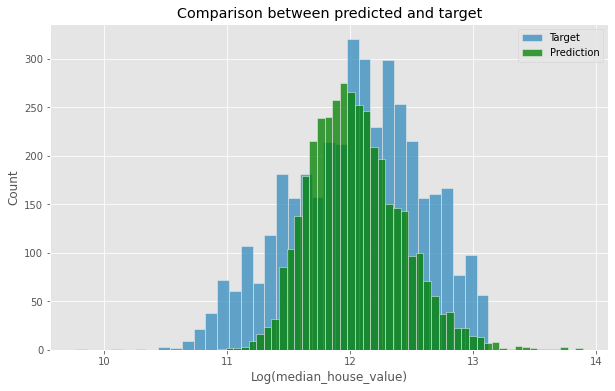

In [17]:
# Plot comparing the predicted values with the target values
plt.figure(figsize=(10, 6))
sns.histplot(y_val, label="Target")
sns.histplot(y_pred, label="Prediction", color="g")
plt.title("Comparison between predicted and target")
plt.xlabel("Log(median_house_value)")
plt.legend()
plt.show()

In [18]:
np.round(rmse(y_val, y_pred=y_pred), 4)

0.3704

Regularizing the model

In [19]:
# Selecting the best model according to the regularization parameter
r = [0, 0.001, 0.01, 0.1, 1.0, 10.0]

for a in r:
    model2 = Ridge(alpha=a, random_state=1).fit(df_train, y_train)
    y_pred = model2.predict(df_val)
    metric = np.round(rmse(y_val, y_pred=y_pred), 6)
    print(f"alpha = {a} | RMSE = {metric}")

alpha = 0 | RMSE = 0.370445
alpha = 0.001 | RMSE = 0.370445
alpha = 0.01 | RMSE = 0.370445
alpha = 0.1 | RMSE = 0.370445
alpha = 1.0 | RMSE = 0.370446
alpha = 10.0 | RMSE = 0.370449


Basically, the RMSE doesn't change. Therefore, regularization is not needed for this problem.

Testing the model

In [20]:
y_pred = model.predict(df_test)

In [21]:
np.round(rmse(y_test, y_pred=y_pred), 4)

0.3708

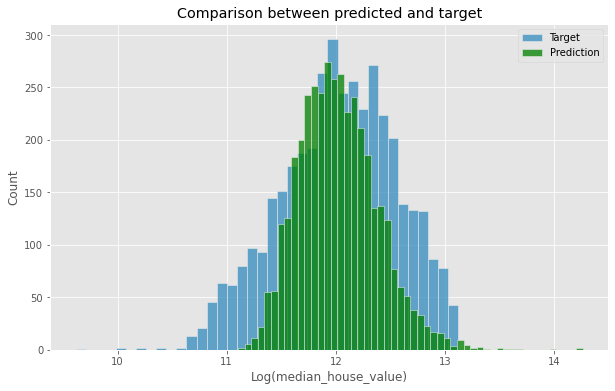

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, label="Target")
sns.histplot(y_pred, label="Prediction", color="g")
plt.title("Comparison between predicted and target")
plt.xlabel("Log(median_house_value)")
plt.legend()
plt.show()

Making a house prediction

In [24]:
# House index = 6672 from the testing subset
testing_house = {
    "housing_median_age": 40.0,
    "total_rooms": 1950.0,
    "total_bedrooms": 509.0,
    "population": 1038.0,
    "households": 438.0,
    "median_income": 2.6172
}

df_test = pd.DataFrame([testing_house])
y_pred = model.predict(df_test)
suggestion = np.expm1(y_pred)
print("The suggested price is: ${:.2f} USD".format(suggestion[0]))
print("The listed price is: $196100.00 USD")

The suggested price is: $150833.78 USD
The listed price is: $196100.00 USD
